# Downscaled `tasmax` days above 40°C

This notebook is for exploring downscaled data for values above 40°C. It was designed to work for the zarr outputs from the 4km ERA5-based CMIP6 downscaling effort. 


Initial testing of the downscaled `tasmax` data revealed that data for the following models had values above 40°C:
* CNRM-CM6-1-HR
* E3SM-2-0
* EC-Earth3-Veg
* HadGEM3-GC31-LL
* HadGEM3-GC31-MM
* KACE-1-0-G
* NorESM2-MM
* TaiESM1

No such values were found in the downscaled historical data, which makes sense as, the maximum value found in the WRF-downscaled 4km t2_max data is approximately 34°C. 

This notebook simply downscaled `tasmax` data with days over 40 °C counted and plotted in red.

In [1]:
import math
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from pathlib import Path
from xclim.core.units import convert_units_to
import matplotlib.pyplot as plt
import gc

zarr_dir = Path(
    os.getenv("ZARR_DIR", "/center1/CMIP6/kmredilla/cmip6_4km_downscaling/adjusted")
)
sim_dir = Path(
    os.getenv("CMIP6_DIR", "/center1/CMIP6/kmredilla/cmip6_4km_downscaling/cmip6_zarr")
)

In [ ]:
def plot_hot_adj_tasmax(model, scenario):
    """Plot maps and histograms of adjusted (downscaled) data highlighting hot pixels."""
    zarr_store = zarr_dir.joinpath(f"tasmax_{model}_{scenario}_adjusted.zarr")

    ds = xr.open_zarr(zarr_store)
    tasmax = convert_units_to(ds.tasmax, "degC")

    # Compute the mean tasmax over time
    tasmax_mean = tasmax.mean("time")

    tasmax_hot = tasmax > 40
    tasmax_hot_count = tasmax_hot.sum("time")

    # Prepare values for histogram
    tasmax_hot_values = tasmax.where(tasmax_hot).values.flatten()
    tasmax_hot_values = tasmax_hot_values[~np.isnan(tasmax_hot_values)]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"Hot tasmax analysis for {model}, {scenario}", fontsize=14)

    # Plot the mean tasmax as a muted background
    axs[0].imshow(
        tasmax_mean.transpose("y", "x").values,
        cmap="Greys",
        alpha=0.5,
        interpolation="none",
    )

    # Overlay the hot day counts using a red color palette, masking zeros for clarity
    masked_hot = np.ma.masked_where(
        tasmax_hot_count.transpose("y", "x") == 0, tasmax_hot_count.transpose("y", "x")
    )
    im = axs[0].imshow(masked_hot, cmap="Reds", alpha=0.8, interpolation="none")

    plt.colorbar(im, ax=axs[0], label="Count of Days > 40°C (Red Overlay)")
    axs[0].set_title("Mean tasmax (grey) with Hot Day Counts (> 40°C) Overlay")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Histogram subplot
    if tasmax_hot_values.size > 0:
        axs[1].hist(tasmax_hot_values, bins=30, color="red", alpha=0.7)
        axs[1].set_xlabel("tasmax (°C)")
        axs[1].set_ylabel("Frequency")
        axs[1].set_title("Histogram of tasmax Values Where tasmax > 40°C")
        percent_above_40 = 100 * tasmax_hot_values.size / tasmax.size
        axs[1].text(
            0.98,
            0.98,
            (
                f"{percent_above_40:.3f}% > 40°C"
                if np.round(percent_above_40, 3) > 0
                else "~0% > 40°C"
            ),
            ha="right",
            va="top",
            transform=axs[1].transAxes,
            fontsize=12,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )
    else:
        axs[1].text(
            0.5,
            0.5,
            "No tasmax values above 40°C found.",
            ha="center",
            va="center",
            fontsize=12,
        )
        axs[1].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    del ds
    del tasmax

    gc.collect()

### CNRM-CM6-1-HR

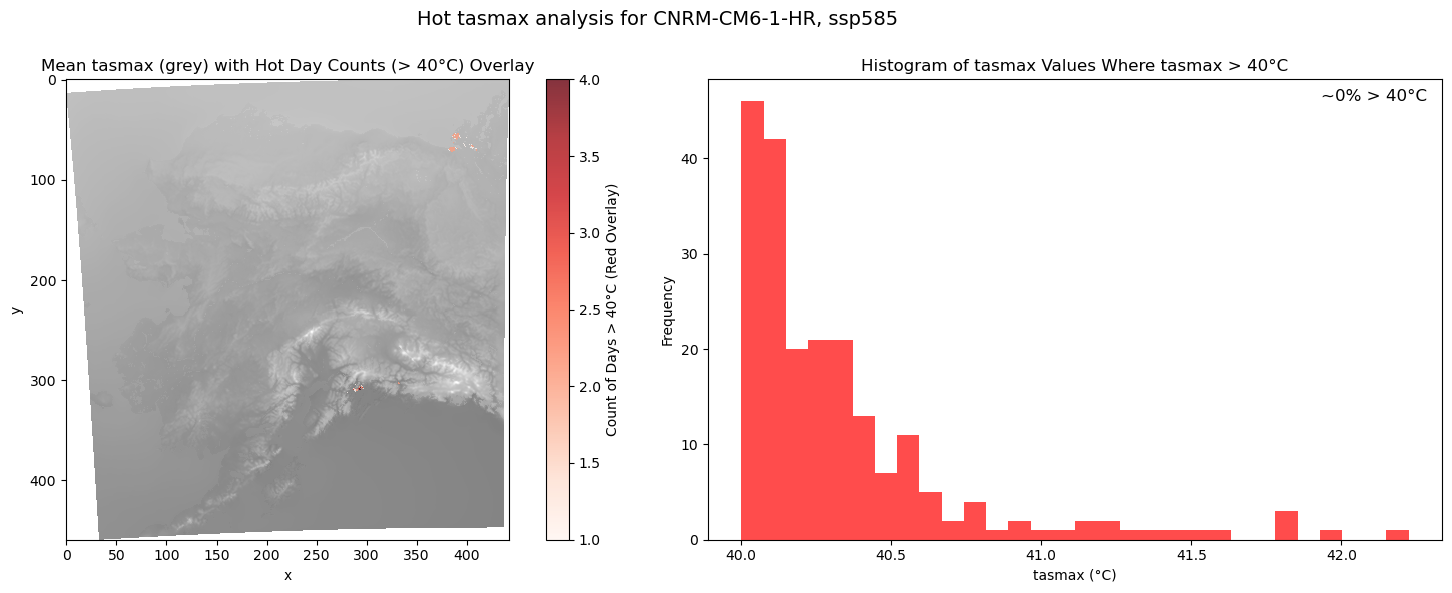

In [15]:
model = "CNRM-CM6-1-HR"
scenario = "ssp585"
plot_hot_adj_tasmax(model, scenario)

### E3SM-2-0

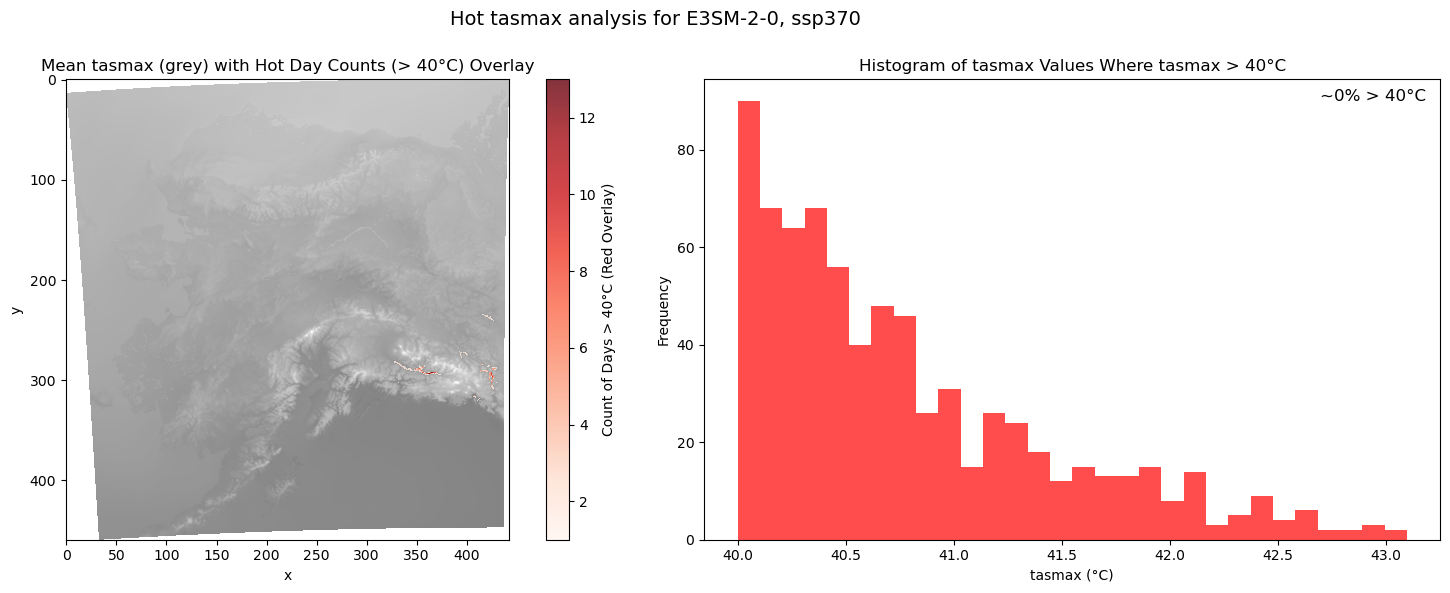

In [16]:
model = "E3SM-2-0"
scenario = "ssp370"
plot_hot_adj_tasmax(model, scenario)

### EC-Earth3-Veg

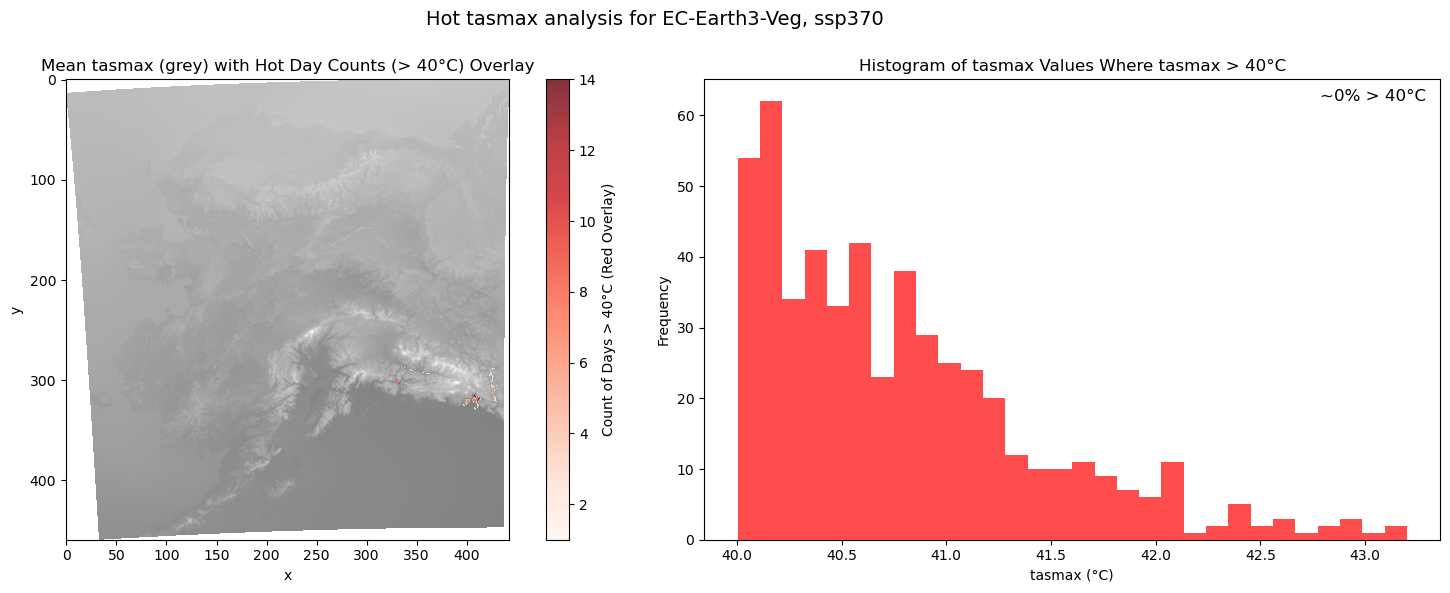

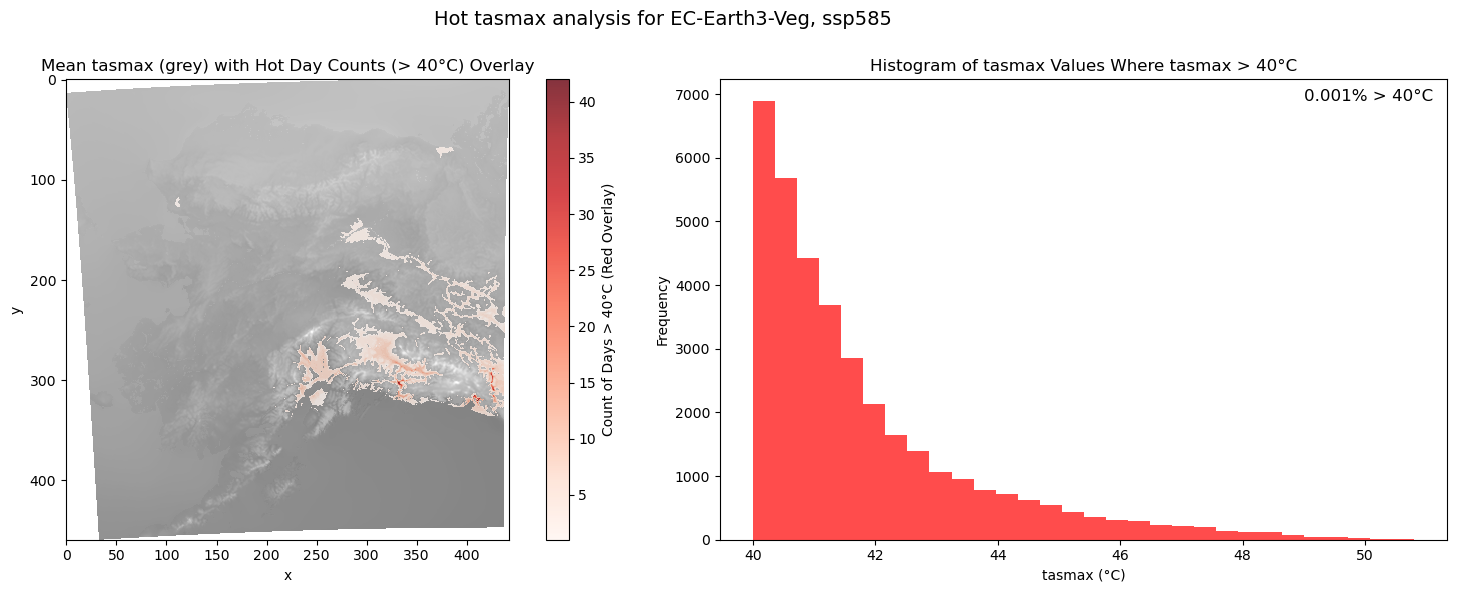

In [17]:
model = "EC-Earth3-Veg"
for scenario in ["ssp370", "ssp585"]:
    plot_hot_adj_tasmax(model, scenario)

### HadGEM3-GC31-LL

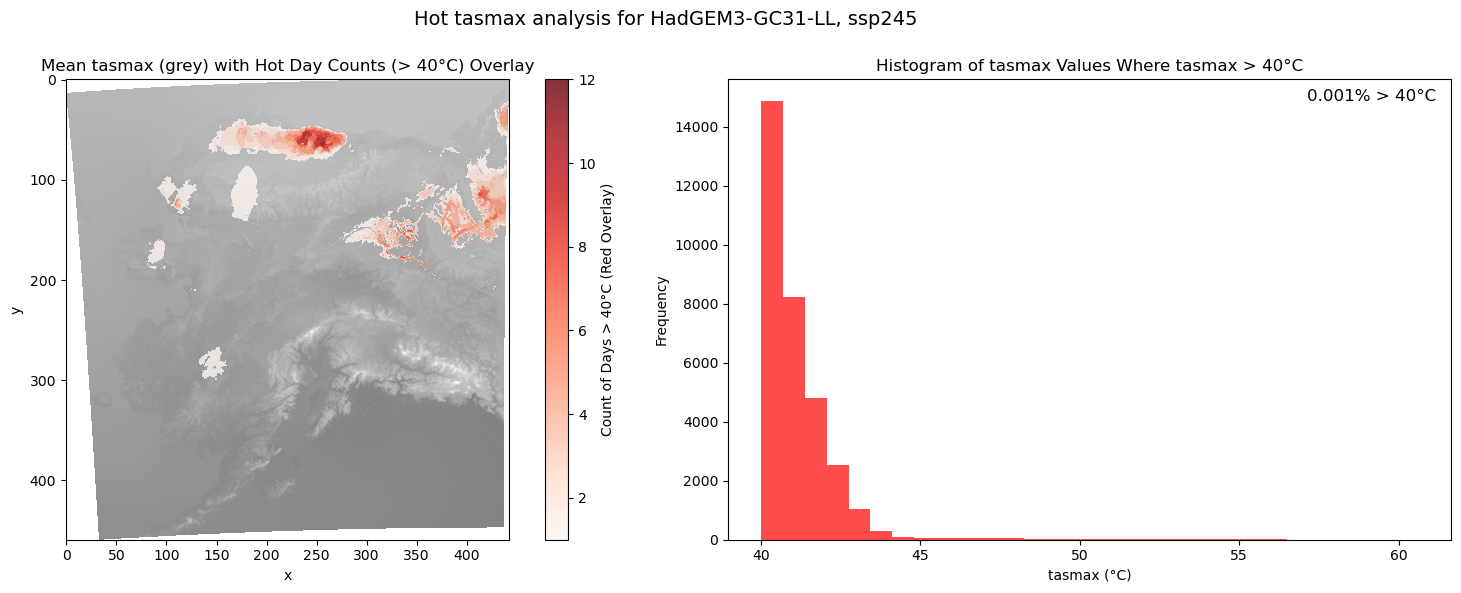

In [18]:
model = "HadGEM3-GC31-LL"
for scenario in ["ssp245", "ssp585"]:
    plot_hot_adj_tasmax(model, scenario)

### HadGEM3-GC31-MM

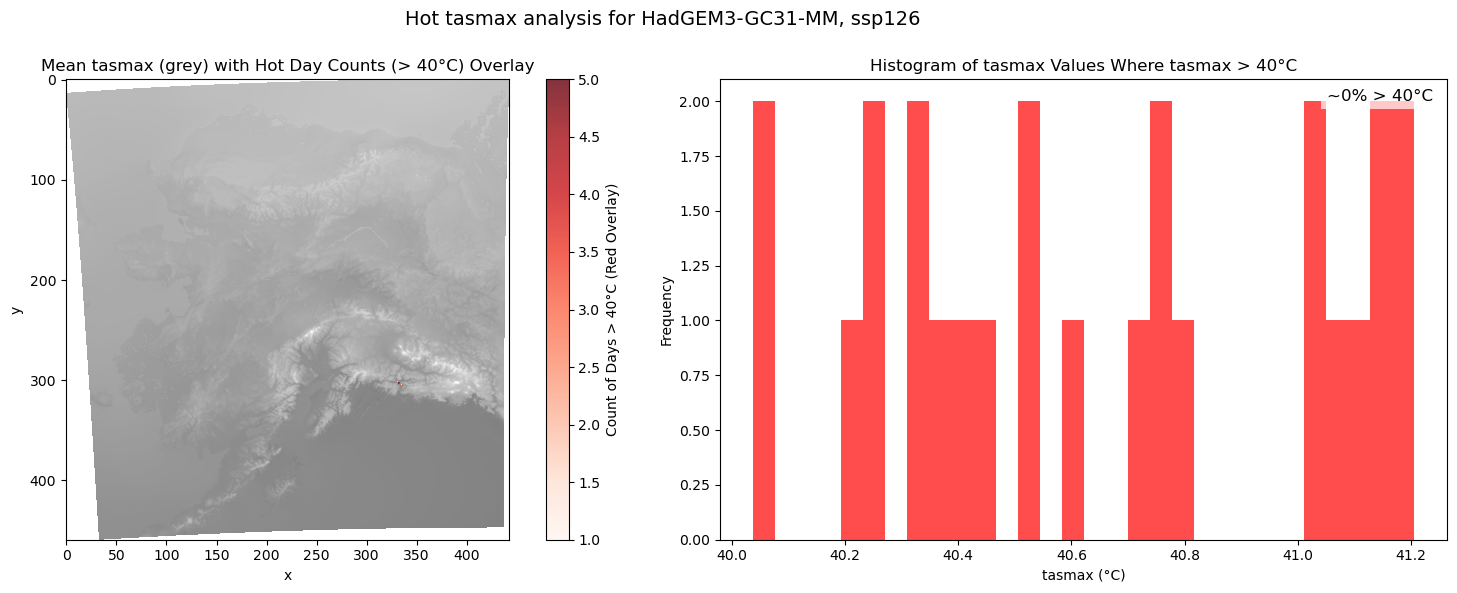

In [19]:
model = "HadGEM3-GC31-MM"
for scenario in ["ssp126", "ssp585"]:
    plot_hot_adj_tasmax(model, scenario)

### KACE-1-0-G

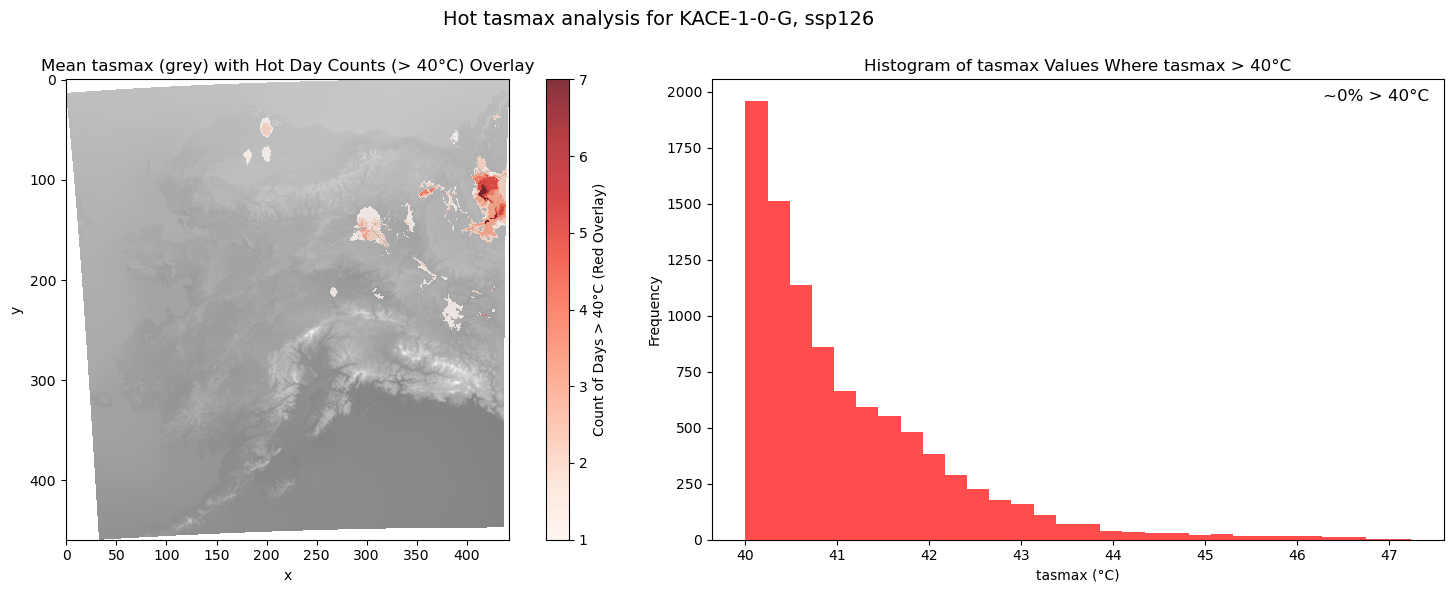

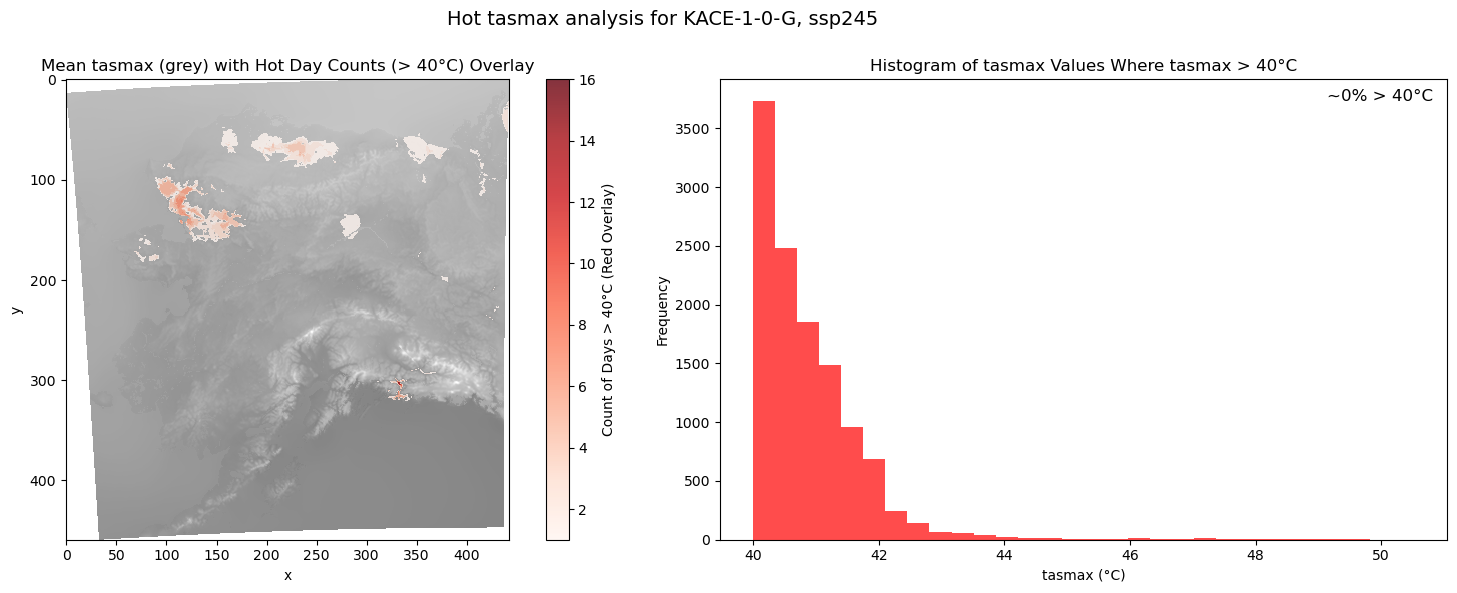

In [20]:
model = "KACE-1-0-G"
for scenario in ["ssp126", "ssp245", "ssp370", "ssp585"]:
    plot_hot_adj_tasmax(model, scenario)

### NorESM2-MM

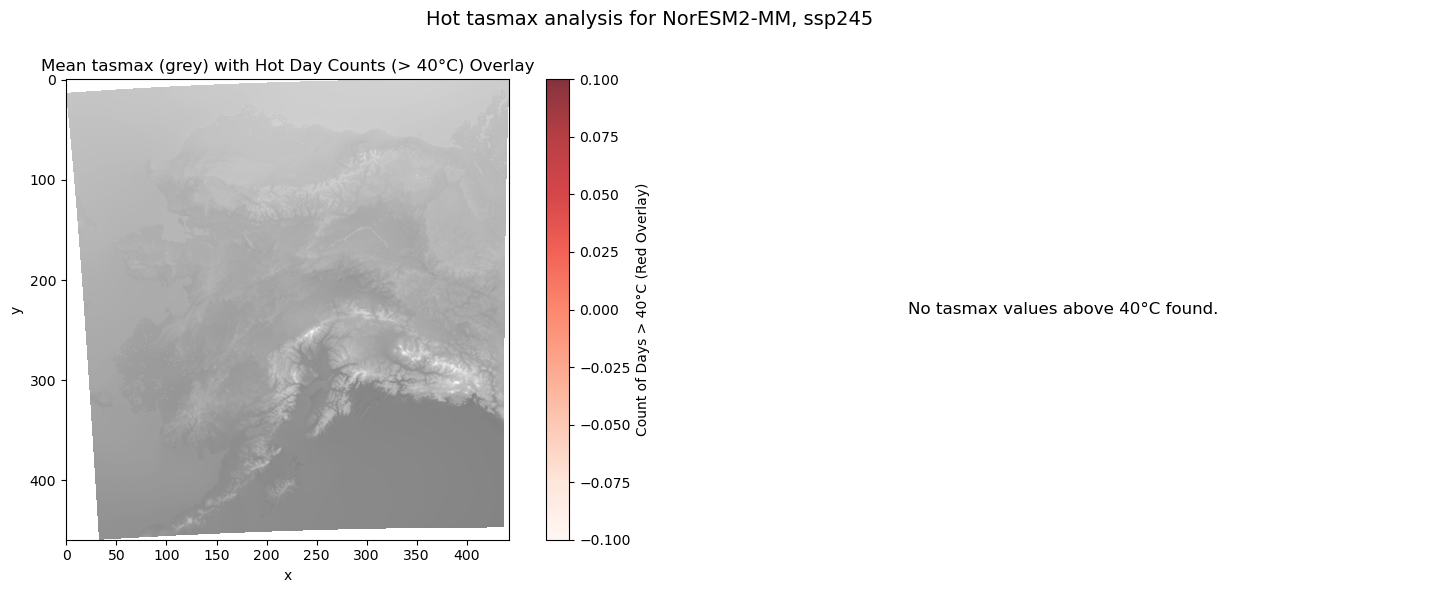

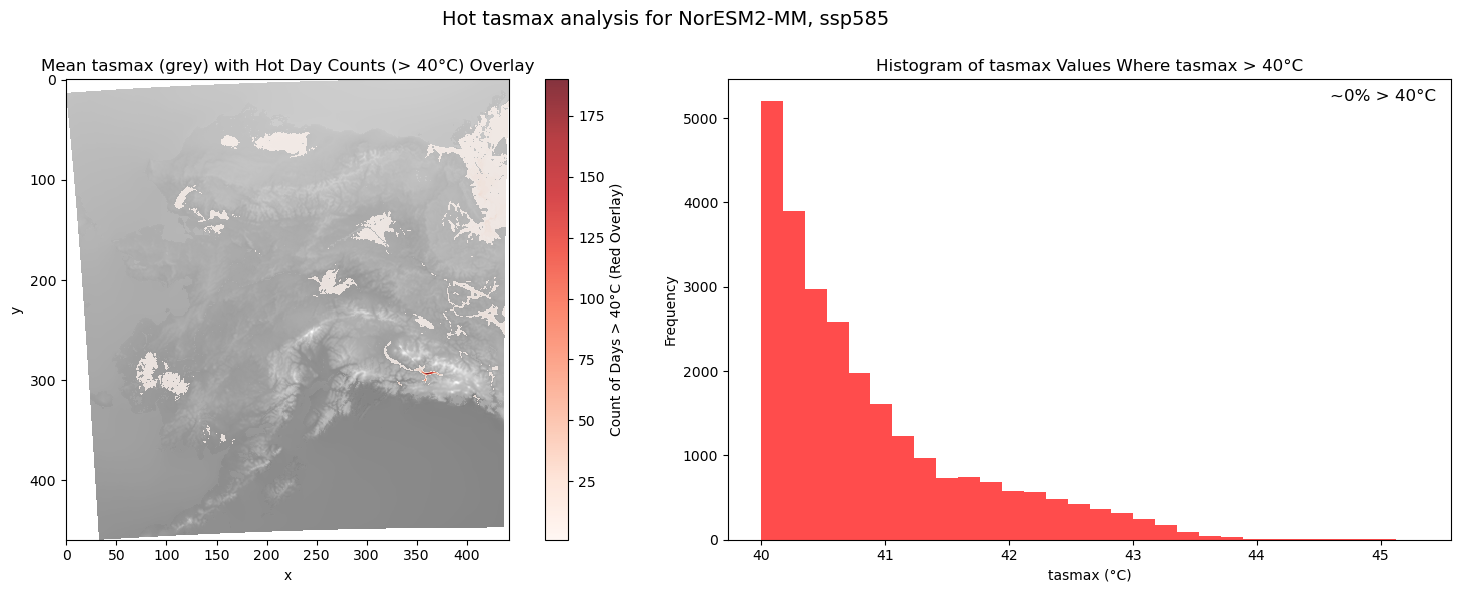

In [21]:
model = "NorESM2-MM"
for scenario in ["ssp245", "ssp585"]:
    plot_hot_adj_tasmax(model, scenario)

### TaiESM1

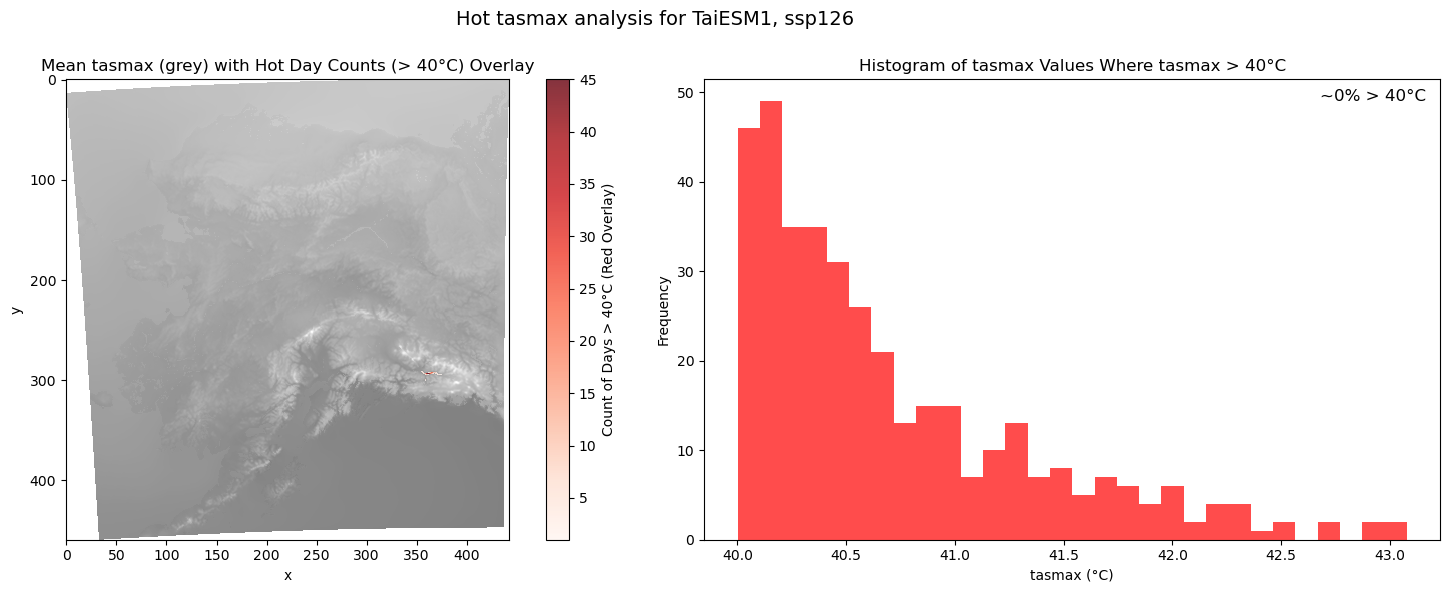

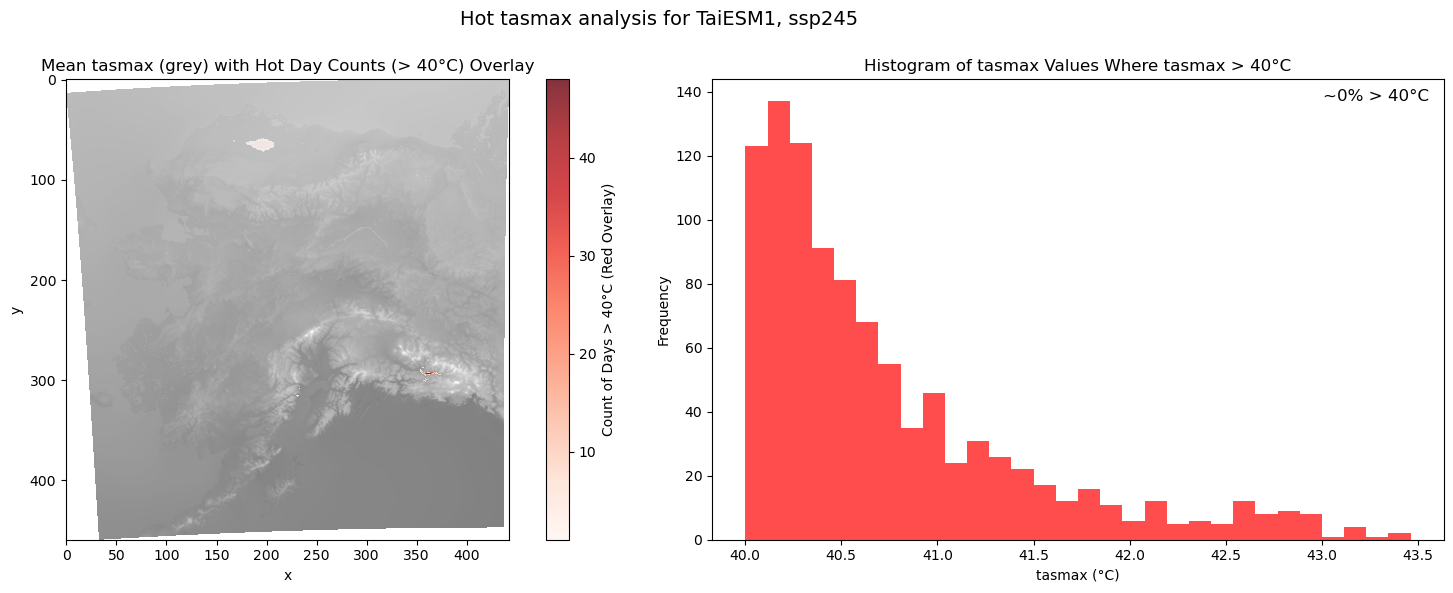

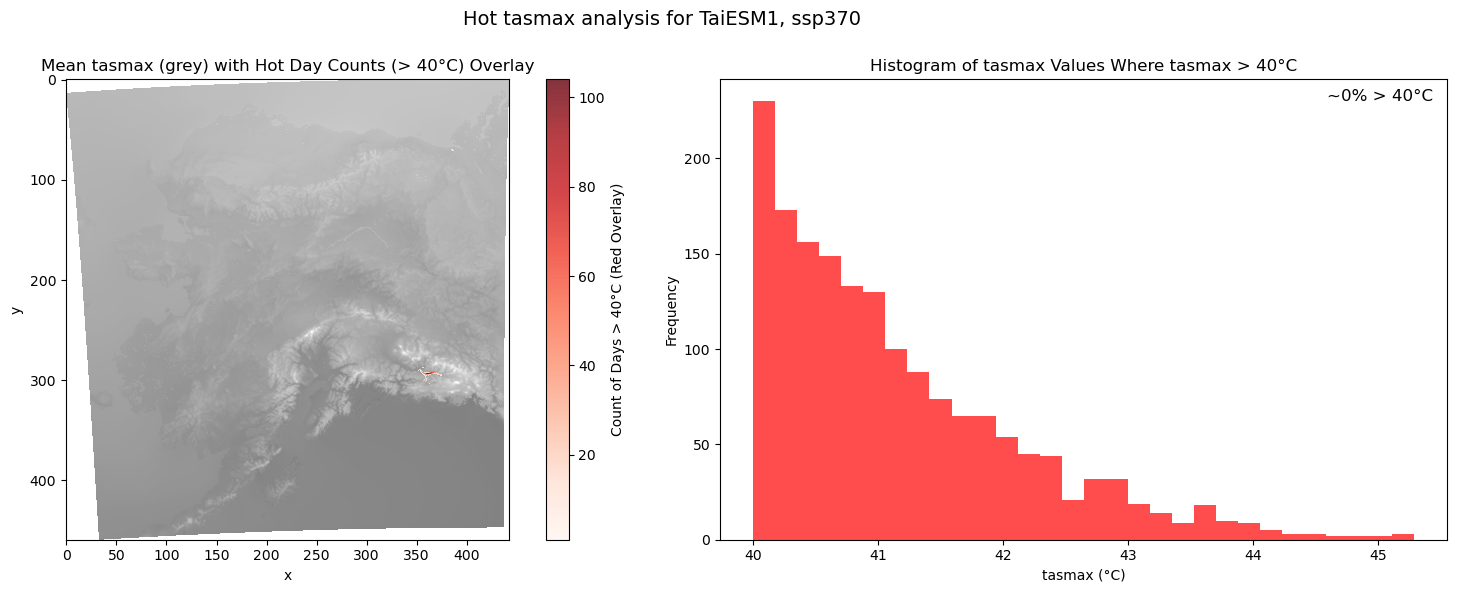

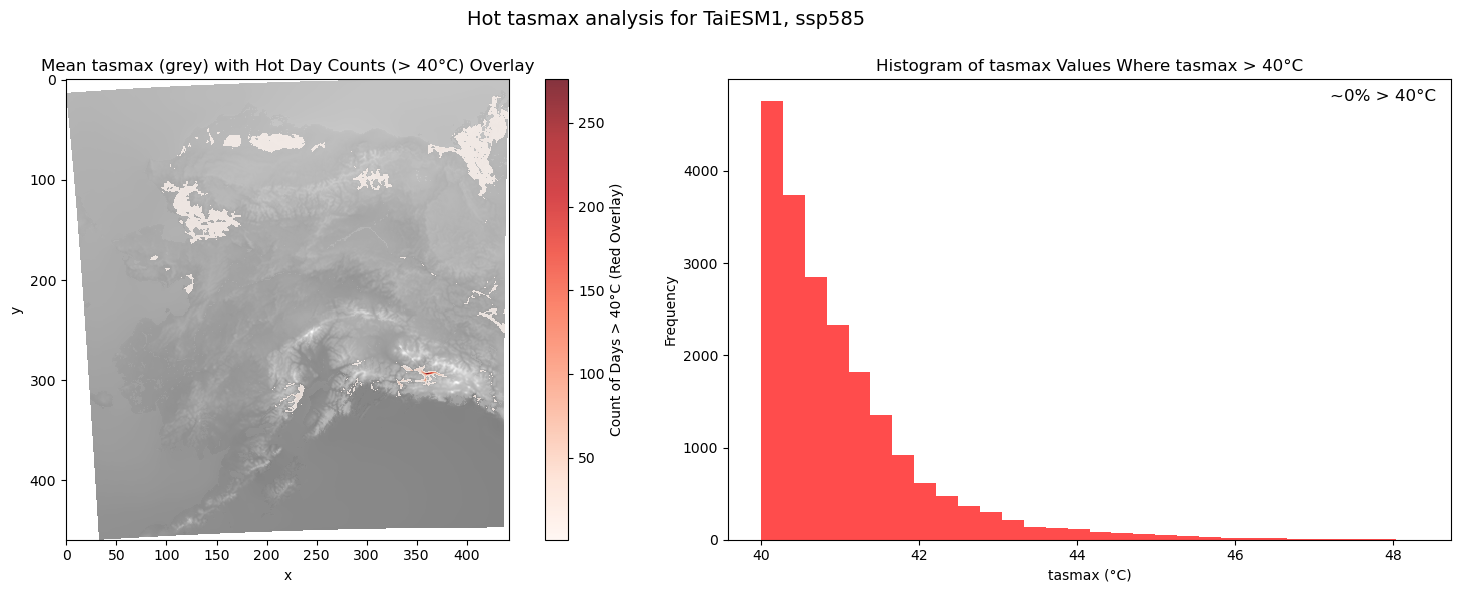

In [22]:
model = "TaiESM1"
for scenario in ["ssp126", "ssp245", "ssp370", "ssp585"]:
    plot_hot_adj_tasmax(model, scenario)

# Exploring the hottest models

Here we will explore a few of the models from the above that have an overabundance of unreasonably high values for `tasmax`. We will plot the following:
* locations of the top 6 hottest pixels
* empirical cumulative distribution functions for all days within 15 days of the maximum value (absolute hottest day) for that pixel
* Day-of-year mean plots for one of those hot pixels
* maps and histograms similar to those above, for the unadjusted raw (but regridded) projected data

In [31]:
ref_dir = Path("/center1/CMIP6/kmredilla/cmip6_4km_downscaling/era5_zarr")
era5_ds = xr.open_dataset(ref_dir.joinpath("t2max_era5.zarr"))

In [ ]:
def open_tasmax(model, scenario):
    zarr_store = zarr_dir.joinpath(f"tasmax_{model}_{scenario}_adjusted.zarr")
    ds = xr.open_zarr(zarr_store)
    tasmax = convert_units_to(ds.tasmax, "degC")
    return tasmax


def get_top6_hot_pixels(tasmax):
    # Count days above 40°C
    hot_days_count = (tasmax > 40).sum(dim="time").load()
    flat_hot = hot_days_count.values.flatten()

    top6_da = hot_days_count.where(hot_days_count >= np.sort(flat_hot)[-6], drop=True)
    top6_yx = np.argwhere(~np.isnan(top6_da.values))
    # limit to top 6
    top6_y = top6_da.y.values[top6_yx[:, 0]][:6]
    top6_x = top6_da.x.values[top6_yx[:, 1]][:6]

    return list(zip(top6_x, top6_y))


def plot_top6_hot_pixels(tasmax, top6_pixels):
    tasmax_mean = tasmax.mean("time")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    tasmax_mean.transpose("y", "x").plot(ax=ax, cmap="Greys")
    top6_x, top6_y = zip(*top6_pixels)
    ax.scatter(top6_x, top6_y, color="red", s=5, label="Top 6 Hot Pixels")
    plt.title("Mean tasmax with Top 6 Hot Pixels (>40°C) Highlighted")
    plt.legend()
    plt.show()


def plot_top6_hot_ecdfs(era5_ds, hist_ds, sim_ds, tasmax, top6_pixels, thresh=None):
    n = len(top6_pixels)
    ncols = math.ceil(n / 2)
    nrows = 2

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4), sharey=True)
    axs = axs.flatten()

    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    for i, (x, y) in enumerate(top6_pixels):
        era5_extr = convert_units_to(
            era5_ds.t2max.sel(x=x, y=y).rename("tasmax"), "degC"
        )
        hist_extr = convert_units_to(hist_ds.tasmax.sel(x=x, y=y), "degC")
        sim_extr = convert_units_to(sim_ds.tasmax.sel(x=x, y=y), "degC")
        tasmax_extr = convert_units_to(tasmax.sel(x=x, y=y), "degC").load()

        max_doy = tasmax_extr.where(
            tasmax_extr == tasmax_extr.max(), drop=True
        ).time.dt.dayofyear.item()
        doys = list(range(max_doy - 15, max_doy)) + list(range(max_doy, max_doy + 15))

        window_df = pd.concat(
            [
                hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_historical")
                .to_dataframe()
                .reset_index(),
                era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source="ERA5")
                .to_dataframe()
                .reset_index(),
                sim_extr.sel(time=sim_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_{scenario}")
                .to_dataframe()
                .reset_index(),
                tasmax_extr.sel(time=tasmax_extr.time.dt.dayofyear.isin(doys))
                .assign_coords(source=f"{model}_{scenario}_downscaled")
                .to_dataframe()
                .reset_index(),
            ]
        )[["time", "source", "tasmax"]]

        sns.ecdfplot(window_df, x="tasmax", hue="source", ax=axs[i])
        if thresh:
            axs[i].set_xlim(left=thresh)
        axs[i].set_title(f"Pixel {i+1}\n(x={x:.0f}, y={y:.0f})")
        axs[i].set_xlabel("tasmax (°C)")
        if i % ncols == 0:
            axs[i].set_ylabel("ECDF")
        else:
            axs[i].set_ylabel("")

    # Hide any unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs[j])

    plt.suptitle(
        (
            f"ECDF of tasmax for Top 6 Hot Pixels (most occurrences of >40°C) for {model}.\n"
            f"Includes only data from 31-day window centered on the day-of-year (DOY: {max_doy}) of the maximum tasmax value (all years)"
        ),
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Compute day-of-year means for sim_ds and hist_ds
def plot_doy_means(era5_ds, hist_ds, sim_ds, tasmax, x, y):
    sim_doy_mean = convert_units_to(
        sim_ds["tasmax"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time"),
        "degC",
    )
    hist_doy_mean = convert_units_to(
        hist_ds["tasmax"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time"),
        "degC",
    )
    ref_doy_mean = convert_units_to(
        era5_ds["t2max"].sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time"),
        "degC",
    )
    tasmax_doy_mean = convert_units_to(
        tasmax.sel(x=x, y=y).groupby("time.dayofyear").mean(dim="time"),
        "degC",
    )

    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    plt.figure(figsize=(9, 5))
    plt.plot(
        sim_doy_mean["dayofyear"],
        sim_doy_mean,
        label=f"{model} {scenario}",
        color="green",
    )
    plt.plot(
        hist_doy_mean["dayofyear"],
        hist_doy_mean,
        label=f"{model} historical",
        color="blue",
    )
    plt.plot(ref_doy_mean["dayofyear"], ref_doy_mean, label="ERA5", color="orange")
    plt.plot(
        tasmax_doy_mean["dayofyear"],
        tasmax_doy_mean,
        label=f"{model} {scenario} downscaled",
        color="red",
    )
    plt.xlabel("Day of Year")
    plt.ylabel("tasmax (°C)")
    plt.title(f"Day-of-Year Mean tasmax: {model}, {scenario}, pixel: (x={x}, y={y})")
    plt.legend()
    plt.tight_layout()
    plt.show()


# function to plot hot tasmax values
def plot_hot_sim_tasmax(sim_ds):
    """plot hot tasmax pixels for unadjusted CMIP6 data"""
    tasmax = convert_units_to(sim_ds.tasmax, "degC")
    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    # Compute the mean tasmax over time
    tasmax_mean = tasmax.mean("time")

    tasmax_hot = tasmax > 40
    tasmax_hot_count = tasmax_hot.sum("time")

    # Prepare values for histogram
    tasmax_hot_values = tasmax.where(tasmax_hot).values.flatten()
    tasmax_hot_values = tasmax_hot_values[~np.isnan(tasmax_hot_values)]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(
        f"Hot tasmax analysis for {model}, {scenario}, NOT bias-adjusted values",
        fontsize=14,
    )

    # Plot the mean tasmax as a muted background
    axs[0].imshow(
        tasmax_mean.transpose("y", "x").values,
        cmap="Greys",
        alpha=0.5,
        interpolation="none",
    )

    # Overlay the hot day counts using a red color palette, masking zeros for clarity
    masked_hot = np.ma.masked_where(
        tasmax_hot_count.transpose("y", "x") == 0, tasmax_hot_count.transpose("y", "x")
    )
    im = axs[0].imshow(masked_hot, cmap="Reds", alpha=0.8, interpolation="none")

    plt.colorbar(im, ax=axs[0], label="Count of Days > 40°C (Red Overlay)")
    axs[0].set_title("Mean tasmax (grey) with Hot Day Counts (> 40°C) Overlay")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    # Histogram subplot
    if tasmax_hot_values.size > 0:
        axs[1].hist(tasmax_hot_values, bins=30, color="red", alpha=0.7)
        axs[1].set_xlabel("tasmax (°C)")
        axs[1].set_ylabel("Frequency")
        axs[1].set_title("Histogram of tasmax Values Where tasmax > 40°C")
    else:
        axs[1].text(
            0.5,
            0.5,
            "No tasmax values above 40°C found.",
            ha="center",
            va="center",
            fontsize=12,
        )
        axs[1].set_axis_off()

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    del sim_ds
    del tasmax

    gc.collect()


def plot_random_ecdf(base, era5_ds, hist_ds, sim_ds, tasmax, ixy=None, thresh=None):
    """plot hot tasmax pixels for unadjusted CMIP6 data"""
    model = sim_ds.attrs.get("source_id")
    scenario = sim_ds.attrs.get("experiment_id")

    # Compute the mean tasmax over time
    # tasmax_mean = tasmax.mean("time")

    fig, axs = plt.subplots(1, 2, figsize=(13, 6))
    fig.suptitle(
        f"Hot tasmax analysis for downscaled {model}, {scenario}",
        fontsize=14,
    )

    # Plot the mean tasmax as a muted background
    base.plot(ax=axs[0], cmap="Greys", alpha=0.5, add_colorbar=False, x="x")

    # get a random pixel if ixy not supplied
    if ixy is None:
        random_x = np.random.choice(base.x.values)
        random_y = np.random.choice(base.y.values)
    else:
        random_x, random_y = base.x.isel(x=ixy[0]).item(), base.y.isel(y=ixy[1]).item()

    # plot the location of the random pixel
    axs[0].scatter(random_x, random_y, color="blue", s=5, label="Random Pixel")

    # extract the random pixel time series for era5_ds, hist_ds, and sim_ds
    era5_extr = convert_units_to(
        era5_ds.t2max.sel(x=random_x, y=random_y).rename("tasmax"), "degC"
    )
    hist_extr = convert_units_to(hist_ds.tasmax.sel(x=random_x, y=random_y), "degC")
    sim_extr = convert_units_to(sim_ds.tasmax.sel(x=random_x, y=random_y), "degC")
    tasmax_extr = convert_units_to(tasmax.sel(x=random_x, y=random_y), "degC").load()

    # Compute the day of year for the maximum tasmax in the historical data and get window of 30 days around it
    max_doy = tasmax_extr.where(
        tasmax_extr == tasmax_extr.max(), drop=True
    ).time.dt.dayofyear.item()
    doys = list(range(max_doy - 15, max_doy)) + list(range(max_doy, max_doy + 15))

    window_df = pd.concat(
        [
            hist_extr.sel(time=hist_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source=f"{model}_historical")
            .to_dataframe()
            .reset_index(),
            era5_extr.sel(time=era5_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source="ERA5")
            .to_dataframe()
            .reset_index(),
            sim_extr.sel(time=sim_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source=f"{model}_{scenario}")
            .to_dataframe()
            .reset_index(),
            tasmax_extr.sel(time=tasmax_extr.time.dt.dayofyear.isin(doys))
            .assign_coords(source=f"{model}_{scenario}_downscaled")
            .to_dataframe()
            .reset_index(),
        ]
    )[["time", "source", "tasmax"]]

    sns.ecdfplot(window_df, x="tasmax", hue="source", ax=axs[1])
    if thresh:
        plt.xlim(left=thresh)
    axs[1].set_xlabel("tasmax (°C)")

    plt.tight_layout()
    plt.show()

    return window_df

### EC-Earth3-Veg, SSP585

Top 6 (x, y) coordinates with highest counts of days > 40°C:
1. (x: 499215.69, y: 1265600.84), count above 40°C: 41
2. (x: 503224.52, y: 1261592.01), count above 40°C: 35
3. (x: 880054.00, y: 1237539.07), count above 40°C: 35
4. (x: 803886.33, y: 1213486.12), count above 40°C: 36
5. (x: 823930.46, y: 1201459.65), count above 40°C: 37
6. (x: 819921.63, y: 1197450.83), count above 40°C: 37


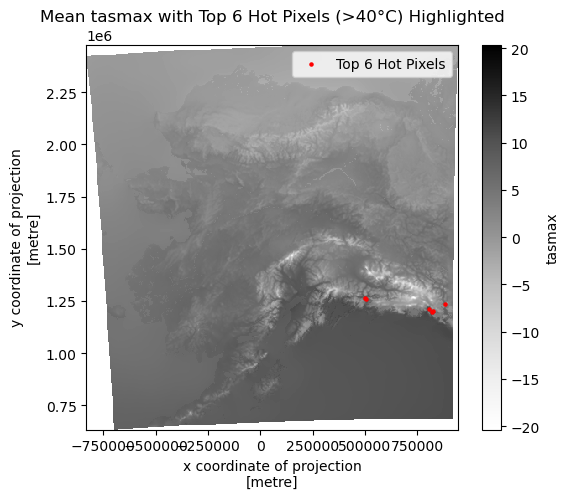

In [34]:
# open the downscaled dataset
model = "EC-Earth3-Veg"
scenario = "ssp585"

tasmax = open_tasmax(model, scenario)
top6_pixels = get_top6_hot_pixels(tasmax)

print("Top 6 (x, y) coordinates with highest counts of days > 40°C:")
for idx, (x, y) in enumerate(top6_pixels, start=1):
    print(
        f"{idx}. (x: {x:.2f}, y: {y:.2f}), count above 40°C: {(tasmax.sel(x=x, y=y).values > 40).sum()}"
    )

plot_top6_hot_pixels(tasmax, top6_pixels)

In [35]:
# open unadjusted, regridded data
hist_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_historical.zarr"))
sim_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_{scenario}.zarr"))

In [65]:
plot_top6_hot_ecdfs(era5_ds, hist_ds, sim_ds, tasmax, top6_pixels)

In [ ]:
plot_doy_means(
    era5_ds, hist_ds, sim_ds, tasmax, x=top6_pixels[0][0], y=top6_pixels[0][1]
)

In [ ]:
plot_hot_sim_tasmax(sim_ds)

ECDFs of some other pixels

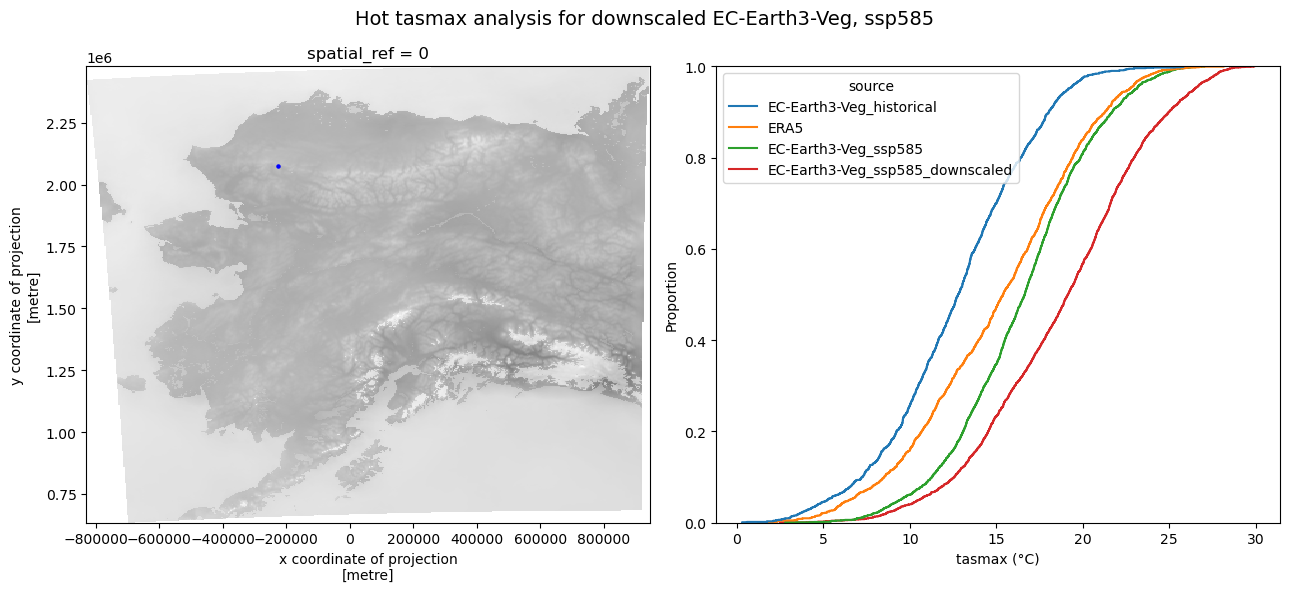

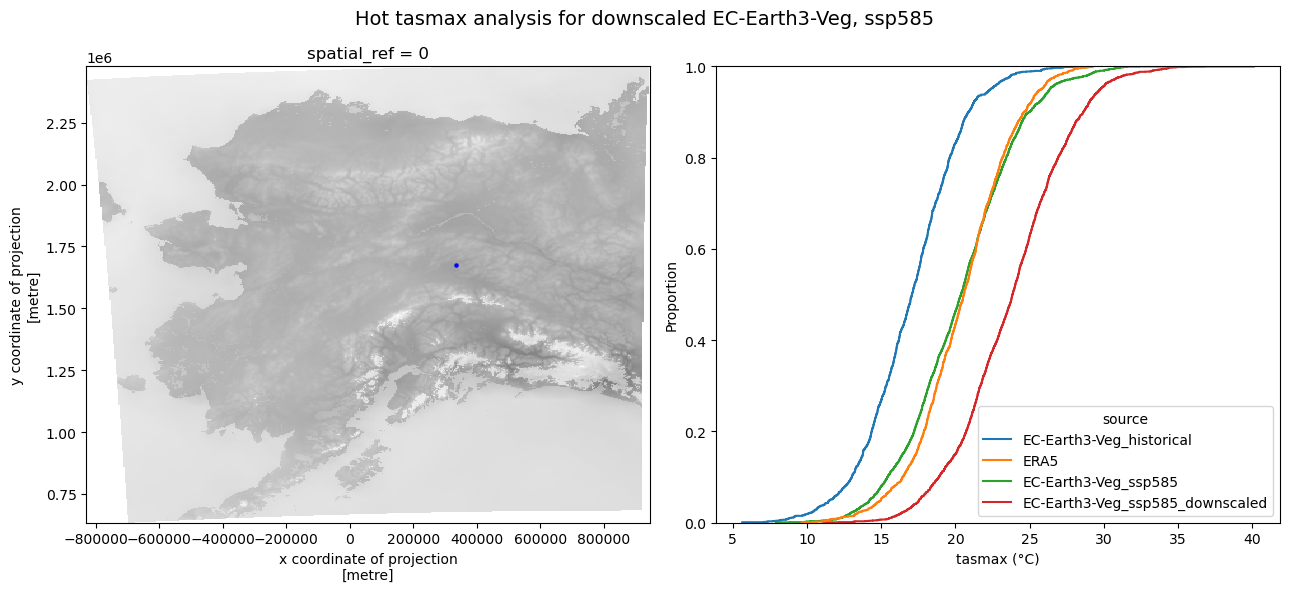

In [53]:
base = tasmax.max("time")
for ixy in [(150, 100), (290, 200), (400, 300)]:
    window_df = plot_random_ecdf(base, era5_ds, hist_ds, sim_ds, tasmax, ixy=ixy)

In [66]:
# open the downscaled dataset
model = "KACE-1-0-G"
scenario = "ssp585"

tasmax = open_tasmax(model, scenario)
top6_pixels = get_top6_hot_pixels(tasmax)

print("Top 6 (x, y) coordinates with highest counts of days > 40°C:")
for idx, (x, y) in enumerate(top6_pixels, start=1):
    print(
        f"{idx}. (x: {x:.2f}, y: {y:.2f}), count above 40°C: {(tasmax.sel(x=x, y=y).values > 40).sum()}"
    )

plot_top6_hot_pixels(tasmax, top6_pixels)

Top 6 (x, y) coordinates with highest counts of days > 40°C:
1. (x: 499215.69, y: 1265600.84), count above 40°C: 86
2. (x: 503224.52, y: 1265600.84), count above 40°C: 54
3. (x: 499215.69, y: 1261592.01), count above 40°C: 62
4. (x: 503224.52, y: 1261592.01), count above 40°C: 69
5. (x: 507233.34, y: 1261592.01), count above 40°C: 6
6. (x: 507233.34, y: 1257583.19), count above 40°C: 58


In [67]:
# open unadjusted, regridded data
hist_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_historical.zarr"))
sim_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_{scenario}.zarr"))

In [70]:
plot_top6_hot_ecdfs(era5_ds, hist_ds, sim_ds, tasmax, top6_pixels)

In [ ]:
plot_doy_means(
    era5_ds, hist_ds, sim_ds, tasmax, x=top6_pixels[0][0], y=top6_pixels[0][1]
)

In [ ]:
plot_hot_sim_tasmax(sim_ds)

ECDFs of some other pixels

/tmp/ipykernel_2352466/1531784889.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  base = tasmax.max("time").drop("spatial_ref")


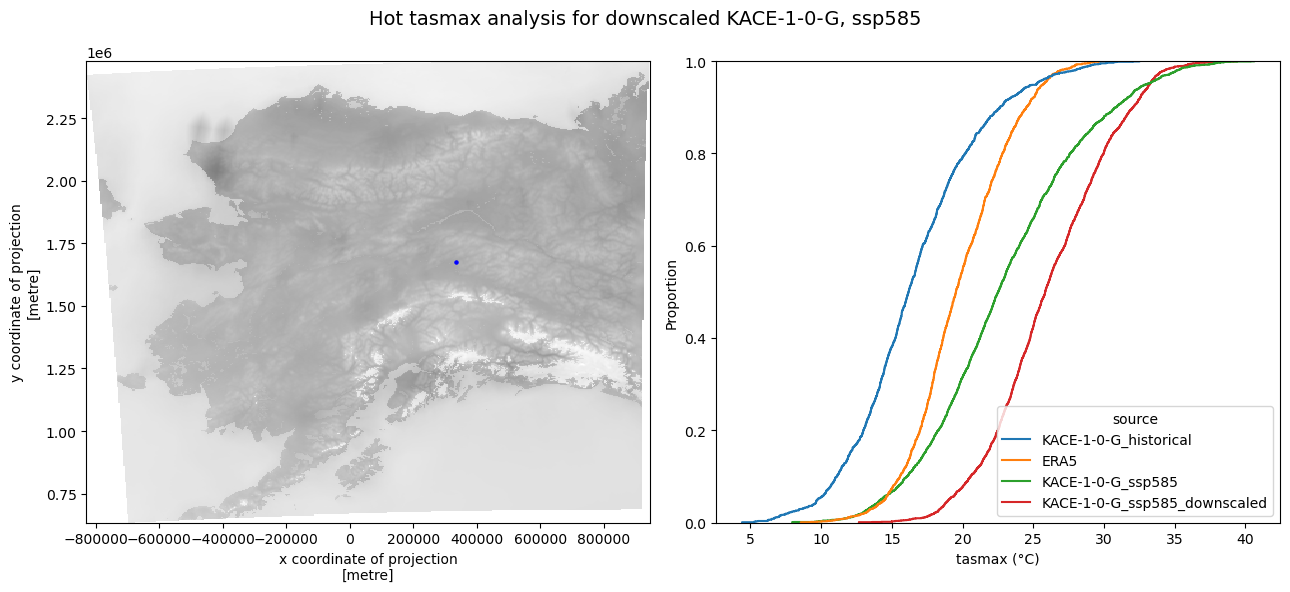

In [76]:
base = tasmax.max("time").drop_vars("spatial_ref")
window_df = plot_random_ecdf(base, era5_ds, hist_ds, sim_ds, tasmax, ixy=(290, 200))

#### HadGEM3-GC31-LL

Top 6 (x, y) coordinates with highest counts of days > 40°C:
1. (x: 130403.86, y: 2267806.90), count above 40°C: 69
2. (x: 126395.04, y: 2263798.07), count above 40°C: 69
3. (x: 138421.51, y: 2263798.07), count above 40°C: 69
4. (x: 134412.69, y: 2259789.25), count above 40°C: 69
5. (x: 138421.51, y: 2255780.42), count above 40°C: 69
6. (x: 142430.34, y: 2255780.42), count above 40°C: 71


/home/kmredilla/miniconda3/envs/cmip6-utils/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


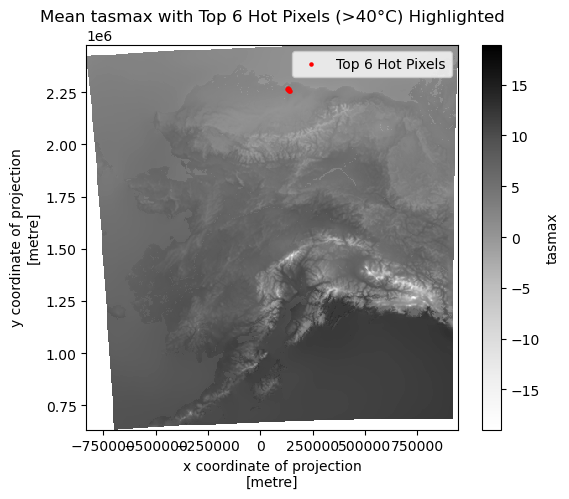

In [77]:
# open the downscaled dataset
model = "HadGEM3-GC31-LL"
scenario = "ssp585"

tasmax = open_tasmax(model, scenario)
top6_pixels = get_top6_hot_pixels(tasmax)

print("Top 6 (x, y) coordinates with highest counts of days > 40°C:")
for idx, (x, y) in enumerate(top6_pixels, start=1):
    print(
        f"{idx}. (x: {x:.2f}, y: {y:.2f}), count above 40°C: {(tasmax.sel(x=x, y=y).values > 40).sum()}"
    )

plot_top6_hot_pixels(tasmax, top6_pixels)

In [78]:
# open unadjusted, regridded data
hist_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_historical.zarr"))
sim_ds = xr.open_dataset(sim_dir.joinpath(f"tasmax_{model}_{scenario}.zarr"))

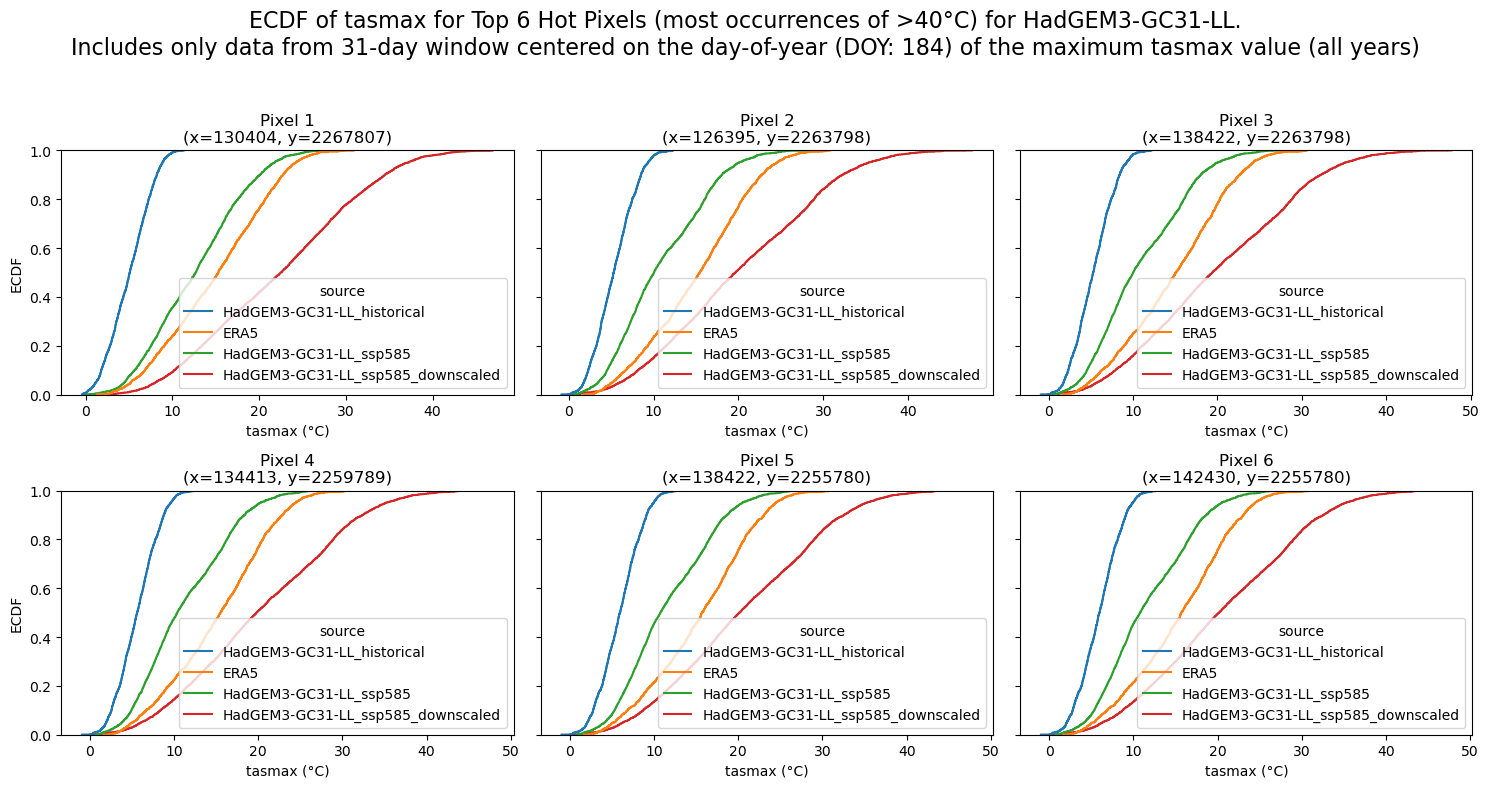

In [79]:
plot_top6_hot_ecdfs(era5_ds, hist_ds, sim_ds, tasmax, top6_pixels)

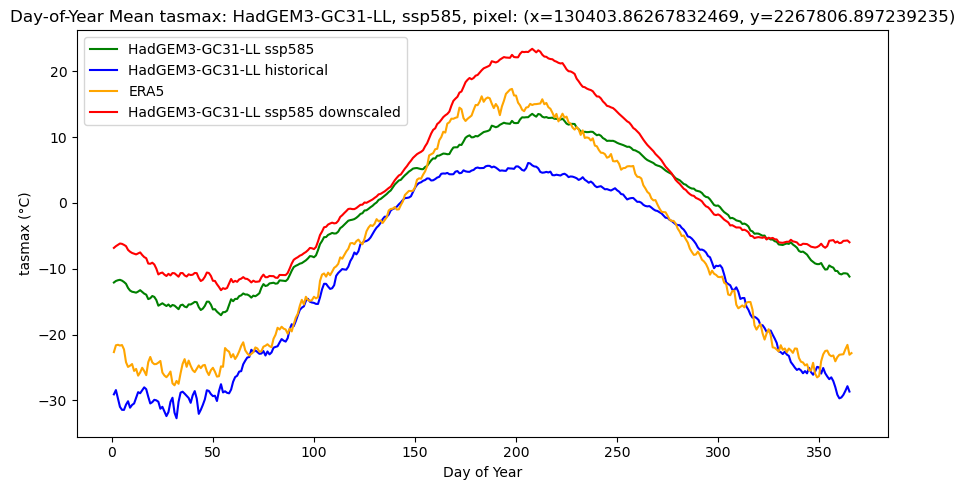

In [ ]:
plot_doy_means(
    era5_ds, hist_ds, sim_ds, tasmax, x=top6_pixels[0][0], y=top6_pixels[0][1]
)

In [26]:
plot_hot_sim_tasmax(sim_ds)

MemoryError: Unable to allocate 23.8 GiB for an array with shape (31390, 460, 443) and data type float32

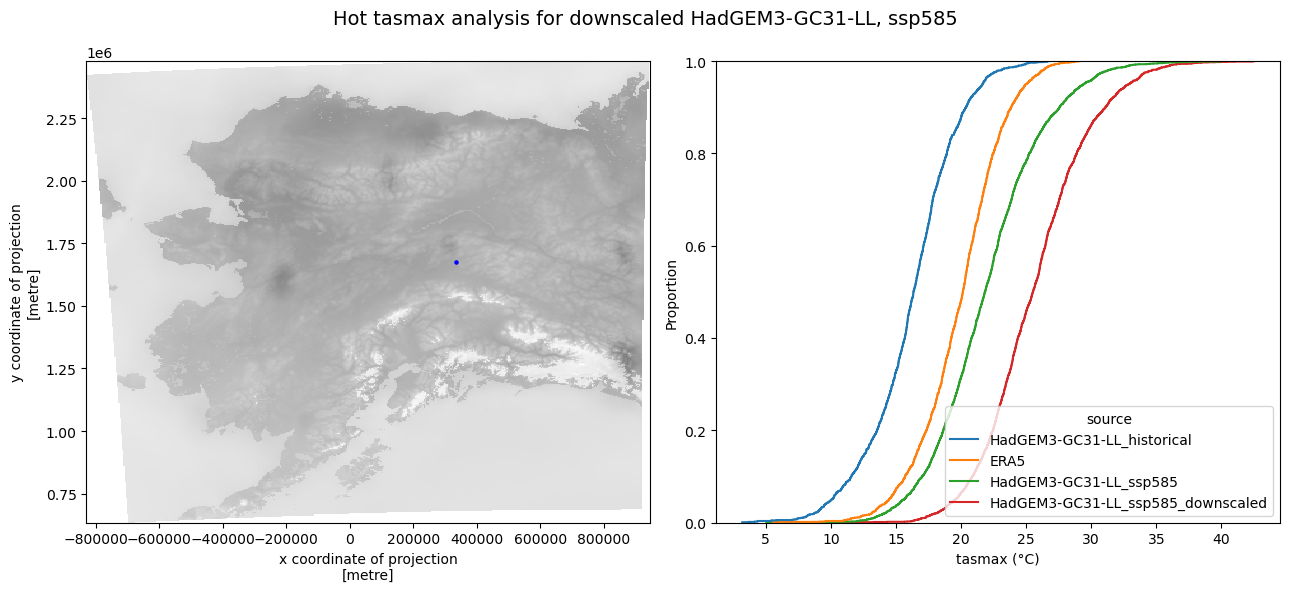

In [81]:
base = tasmax.max("time").drop_vars("spatial_ref")
window_df = plot_random_ecdf(base, era5_ds, hist_ds, sim_ds, tasmax, ixy=(290, 200))